In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.data import Dataset, DataLoader
import cv2
import pandas as pd
from PIL import Image

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
class DeepfakeSatelliteImageDataset(Dataset):
    """Deepfake satellite image dataset."""

    def __init__(self, csv_file, mode, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file.
            mode (string): "train", "test" or "val".
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.images = pd.read_csv(csv_file)
        self.images = self.images[self.images["SET"] == mode]
        self.images = self.images[self.images["isFake"] == 1]
        
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.images.iloc[idx]["FP"])
        image = cv2.imread(img_name)
        image = image[:,:,::-1]
        if self.transform:
            image = self.transform(image=image)["image"]
        return image, int(self.images.iloc[idx]["isFake"])

In [3]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': A.Compose([
        A.Resize(244,244),
        A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ToTensorV2()
    ]),
    'val': A.Compose([
        A.Resize(244,244),
        A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ToTensorV2()
    ]),
    'test': A.Compose([
        A.Resize(244,244),
        A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ToTensorV2()
    ]),
}

In [4]:
csv_file = "../split/data_10_10_80.csv"
image_datasets = {x: DeepfakeSatelliteImageDataset(csv_file=csv_file, mode=x, transform=data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=128,
                                             shuffle=True, num_workers=16)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
print(len(image_datasets['train']))
print(len(image_datasets['val']))
print(len(image_datasets['test']))

407
410
3215


In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis("off")
    plt.show()
#     if title is not None:
#         plt.title(title)
#     plt.pause(0.001)  # pause a bit so that plots are updated

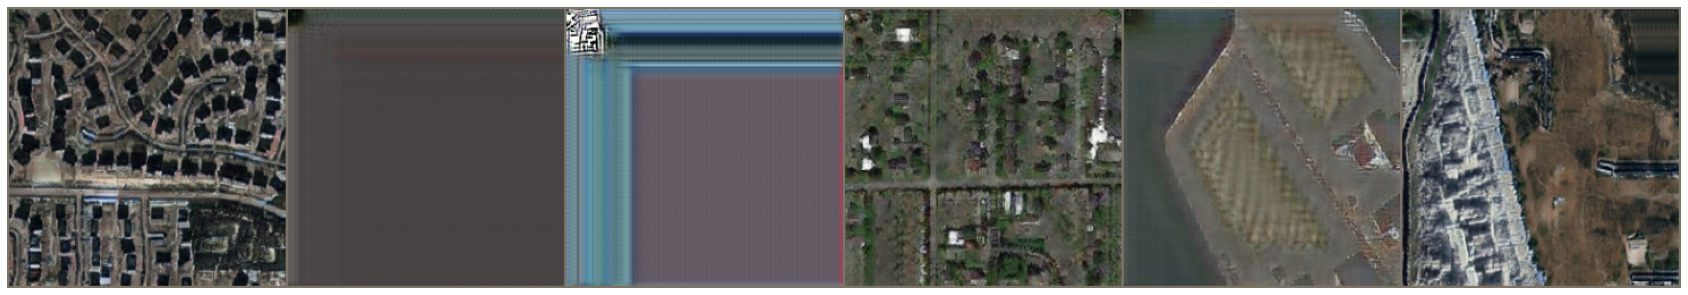

In [7]:
class_names = ['real', 'fake']
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:6])

plt.figure(figsize=(30,15))
imshow(out, title=[class_names[x] for x in classes[:6]])

In [8]:
log_path = "records/resnet18/" + csv_file.split("/")[-1].replace(".csv", ".txt")
os.makedirs("records/resnet18/", exist_ok=True)

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        with open(log_path, 'a') as f:
            f.write('Epoch {}/{}\n'.format(epoch, num_epochs - 1))

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            with open(log_path, 'a') as f:
                f.write('{} Loss: {:.4f} Acc: {:.4f}\n'.format(phase, epoch_loss, epoch_acc))
                
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    with open(log_path, 'a') as f:
        f.write('Training complete in {:.0f}m {:.0f}s\n'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    with open(log_path, 'a') as f:
        f.write('Best val Acc: {:4f}\n'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [10]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
train Loss: 0.3166 Acc: 0.9705
val Loss: 0.1279 Acc: 1.0000

Epoch 1/49
----------
train Loss: 0.0469 Acc: 1.0000
val Loss: 0.0208 Acc: 1.0000

Epoch 2/49
----------
train Loss: 0.0064 Acc: 1.0000
val Loss: 0.0046 Acc: 1.0000

Epoch 3/49
----------
train Loss: 0.0016 Acc: 1.0000
val Loss: 0.0014 Acc: 1.0000

Epoch 4/49
----------
train Loss: 0.0006 Acc: 1.0000
val Loss: 0.0006 Acc: 1.0000

Epoch 5/49
----------
train Loss: 0.0003 Acc: 1.0000
val Loss: 0.0003 Acc: 1.0000

Epoch 6/49
----------
train Loss: 0.0002 Acc: 1.0000
val Loss: 0.0002 Acc: 1.0000

Epoch 7/49
----------
train Loss: 0.0002 Acc: 1.0000
val Loss: 0.0002 Acc: 1.0000

Epoch 8/49
----------
train Loss: 0.0002 Acc: 1.0000
val Loss: 0.0002 Acc: 1.0000

Epoch 9/49
----------
train Loss: 0.0002 Acc: 1.0000
val Loss: 0.0002 Acc: 1.0000

Epoch 10/49
----------
train Loss: 0.0002 Acc: 1.0000
val Loss: 0.0002 Acc: 1.0000

Epoch 11/49
----------
train Loss: 0.0002 Acc: 1.0000
val Loss: 0.0002 Acc: 1.0000

Ep

In [11]:
best_state_dict = model_ft.state_dict()
save_path = "records/resnet18/" + csv_file.split("/")[-1].replace("csv", "ckpt")
torch.save(best_state_dict, save_path)

In [12]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

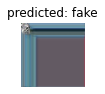

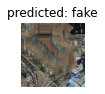

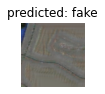

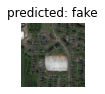

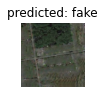

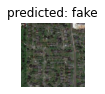

In [13]:
visualize_model(model_ft)

### Test

In [14]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for X, y in dataloader:
            y_true.extend(list(y))
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            pred = pred.argmax(1)
            y_pred.extend(list(pred.cpu()))
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    with open(log_path, 'a') as f:
        f.write('Test f1_score: {:6f} precision: {:6f} recall: {:6f}\n'.format(f1_score(y_true, y_pred), precision_score(y_true, y_pred), recall_score(y_true, y_pred)))
        f.write(f"Test Error: \n Accuracy: {(100*correct):>0.2f}%, Avg loss: {test_loss:>8f} \n")
    print([f1_score(y_true, y_pred),  precision_score(y_true, y_pred), recall_score(y_true, y_pred)])
    print(np.sum(y_true), len(y_true)-np.sum(y_true))
test_dataset = image_datasets['test']
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=16)
model_ft.load_state_dict(torch.load(save_path))
test(test_dataloader, model_ft, criterion)

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.127545 

[1.0, 1.0, 1.0]
3215 0
